In [ ]:
def classifier(X, y, pipeline, param_grid, base_route, iterations=100, scoring='roc_auc'):
    scorings=[]
    best_params = {}
    for key in param_grid:
        best_params[key] = []
    
    for it in range(iterations):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        estimator = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, return_train_score=True)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=it)
        route = base_route+str(it)+'.pkl'
        
        if os.path.isfile(route):
            fitted_model = pickle.load(open(route, 'rb'))
        else:
            fitted_model = estimator.fit(X_train, y_train)
            pickle.dump(fitted_model, open(route, 'wb'))
        
        for key in best_params:
            best_params[key].append(fitted_model.best_params_[key])
            
        predic_proba = fitted_model.predict_proba(X_test)[:, 1]
        scorings.append(roc_auc_score(y_test, predic_proba))
            
    return scorings, best_params

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pickle
import statistics as stat
import os

In [ ]:
path_csv_features = 'data/'
preprocess_method = 'comert'
features = pd.read_csv(path_csv_features+preprocess_method+'_gaps_features.csv', index_col=0)
path_csv_clinical = 'data/'
clinical_df = pd.read_csv(path_csv_clinical+'clinical_ctu-chb.csv', index_col=0, compression='gzip')
df = features

df['y'] = np.where(clinical_df['ph'] < 7.2, 1, 0)
df = df.dropna()
df = df.loc[:, df.columns != 'SampEn015']
df = df.loc[:, df.columns != 'SampEn020']

# normalize df
df_normalized=(df-df.mean())/df.std()

X1 = df_normalized[['baseline', 'DCC', 'ACC', 'mean', 'std',	'LTV', 'delta',	'STV', 'II']]
X2 = df_normalized[['baseline', 'DCC', 'ACC', 'mean', 'std',	'LTV', 'delta',	'STV', 'II', 'ApEn015', 'ApEn020', 'LZC']]
X3 = df_normalized[df.columns.difference(['y'])]
y = df['y']

In [ ]:
X1.head()

,baseline,DCC,ACC,mean,std,LTV,delta,STV,II
1001,0.371055,0.370733,0.465332,-0.041659,0.668120,-0.034609,-0.066091,-0.223041,-0.992970
1002,-1.273967,0.786379,1.215912,-0.821005,1.608923,-0.886490,1.652657,0.370667,-1.048297
1003,-1.372127,-0.876208,-0.660538,-1.547037,0.313104,-1.592909,-0.983422,-0.735504,-1.297048
1004,-1.000015,1.617673,2.341782,-0.869039,1.329032,-0.920700,0.933752,0.501385,-0.795630
1005,-1.333700,-0.044914,0.090042,-1.381983,0.339428,-1.403628,0.481325,0.289339,-0.114214


In [ ]:
X2.head()

,baseline,DCC,ACC,mean,std,LTV,delta,STV,II,ApEn015,ApEn020,LZC
1001,0.371055,0.370733,0.465332,-0.041659,0.668120,-0.034609,-0.066091,-0.223041,-0.992970,-0.618193,-0.628579,-0.139240
1002,-1.273967,0.786379,1.215912,-0.821005,1.608923,-0.886490,1.652657,0.370667,-1.048297,-0.618193,-0.628579,-0.074812
1003,-1.372127,-0.876208,-0.660538,-1.547037,0.313104,-1.592909,-0.983422,-0.735504,-1.297048,-0.216749,-0.174785,-0.912379
1004,-1.000015,1.617673,2.341782,-0.869039,1.329032,-0.920700,0.933752,0.501385,-0.795630,-0.337375,-0.347681,-0.139240
1005,-1.333700,-0.044914,0.090042,-1.381983,0.339428,-1.403628,0.481325,0.289339,-0.114214,-0.513750,-0.524106,-0.976807


In [ ]:
X3.head()

,ACC,ApEn015,ApEn020,DCC,II,LTV,LZC,STV,baseline,contrast HF,...,energy HF,energy LF,energy MF,energy VLF,homogeneity HF,homogeneity LF,homogeneity MF,homogeneity VLF,mean,std
1001,0.465332,-0.618193,-0.628579,0.370733,-0.992970,-0.034609,-0.139240,-0.223041,0.371055,-1.116777,...,-0.040932,-0.078760,0.379262,-0.734966,0.193581,0.116293,0.239711,0.421862,-0.041659,0.668120
1002,1.215912,-0.618193,-0.628579,0.786379,-1.048297,-0.886490,-0.074812,0.370667,-1.273967,-0.534793,...,1.013918,0.264007,1.005997,-0.880381,1.297752,0.435256,0.698201,0.440853,-0.821005,1.608923
1003,-0.660538,-0.216749,-0.174785,-0.876208,-1.297048,-1.592909,-0.912379,-0.735504,-1.372127,-0.626955,...,0.079011,0.899446,0.716577,0.780339,-0.039330,1.038202,0.369768,-0.426147,-1.547037,0.313104
1004,2.341782,-0.337375,-0.347681,1.617673,-0.795630,-0.920700,-0.139240,0.501385,-1.000015,1.117290,...,2.299462,-1.298181,-0.490796,-2.239486,1.469326,-1.332730,-0.358917,0.594461,-0.869039,1.329032
1005,0.090042,-0.513750,-0.524106,-0.044914,-0.114214,-1.403628,-0.976807,0.289339,-1.333700,0.279301,...,-0.223211,-0.613450,-1.318542,-1.012053,-0.059617,-0.680830,-1.240000,0.162099,-1.381983,0.339428


### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
pipeline = LinearDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/base_features/lda/'

#scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route)
mean_base_lda = 0.595
std_base_lda = 0.037

print("Resultados con features base: " + "%.3f" % mean_base_lda + ' +/- ' + "%.3f" % std_base_lda)

base_route = 'modelos/mid_features/lda/'
#scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route)
mean_mid_lda = 0.592
std_mid_lda = 0.037

print("Resultados con features intermedias: " + "%.3f" % mean_mid_lda + ' +/- ' + "%.3f" % std_mid_lda)

base_route = 'modelos/all_features/lda/'
#scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route)
mean_all_lda = 0.598
std_all_lda = 0.038

print("Resultados con todas las features: " + "%.3f" % mean_all_lda + ' +/- ' + "%.3f" % std_all_lda)

Resultados con features base: 0.595 +/- 0.037
Resultados con features intermedias: 0.592 +/- 0.037
Resultados con todas las features: 0.598 +/- 0.038


### QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
pipeline = QuadraticDiscriminantAnalysis()
param_grid = {}
base_route = 'modelos/base_features/qda/'

#scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route)
mean_base_qda = 0.591
std_base_qda = 0.039

print("Resultados con features base: " + "%.3f" % mean_base_qda + ' +/- ' + "%.3f" % std_base_qda)

base_route = 'modelos/mid_features/qda/'
#scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route)
mean_mid_qda = 0.589
std_mid_qda = 0.042

print("Resultados con features intermedias: " + "%.3f" % mean_mid_qda + ' +/- ' + "%.3f" % std_mid_qda)

base_route = 'modelos/all_features/qda/'
#scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route)
mean_all_qda = 0.559
std_all_qda = 0.035

print("Resultados con todas las features: " + "%.3f" % mean_all_qda + ' +/- ' + "%.3f" % std_all_qda)

Resultados con features base: 0.591 +/- 0.039
Resultados con features intermedias: 0.589 +/- 0.042
Resultados con todas las features: 0.559 +/- 0.035


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pipeline = LogisticRegression(max_iter=1000)
solvers = ['liblinear', 'sag']
c_values = np.logspace(-2.0, 3.0, num=6)
param_grid = {'solver': solvers, 'C': c_values}
base_route = 'modelos/base_features/logreg/'

#scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route)
mean_base_logreg = 0.595
std_base_logreg = 0.035

print("Resultados con features base: " + "%.3f" % mean_base_logreg + ' +/- ' + "%.3f" % std_base_logreg)

base_route = 'modelos/mid_features/logreg/'
#scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route)
mean_mid_logreg = 0.589
std_mid_logreg = 0.042

print("Resultados con features intermedias: " + "%.3f" % mean_mid_logreg + ' +/- ' + "%.3f" % std_mid_logreg)

base_route = 'modelos/all_features/logreg/'
#scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route)
mean_all_logreg = 0.595
std_all_logreg = 0.039

print("Resultados con todas las features: " + "%.3f" % mean_all_logreg + ' +/- ' + "%.3f" % std_all_logreg)

Resultados con features base: 0.595 +/- 0.035
Resultados con features intermedias: 0.589 +/- 0.042
Resultados con todas las features: 0.595 +/- 0.039


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipeline = KNeighborsClassifier()
param_grid = {'leaf_size': list(range(20,40)),
'n_neighbors': list(range(1,30,2)),
'p': [1, 2]}
base_route = 'modelos/base_features/knn/'

#scorings, best_params = classifier(X1, y, pipeline, param_grid, base_route)
mean_base_knn = 0.572
std_base_knn = 0.046

print("Resultados con features base: " + "%.3f" % mean_base_knn + ' +/- ' + "%.3f" % std_base_knn)

base_route = 'modelos/mid_features/knn/'
#scorings, best_params = classifier(X2, y, pipeline, param_grid, base_route)
mean_mid_knn = 0.583
std_mid_knn = 0.046

print("Resultados con features intermedias: " + "%.3f" % mean_mid_knn + ' +/- ' + "%.3f" % std_mid_knn)

base_route = 'modelos/all_features/knn/'
#scorings, best_params = classifier(X3, y, pipeline, param_grid, base_route)
mean_all_knn = 0.561
std_all_knn = 0.040

print("Resultados con todas las features: " + "%.3f" % mean_all_knn + ' +/- ' + "%.3f" % std_all_knn)
#!zip -r /content/modelos_roc_auc.zip /content/modelos/
#from google.colab import files
#files.download("/content/modelos_roc_auc.zip")

Resultados con features base: 0.572 +/- 0.046
Resultados con features intermedias: 0.583 +/- 0.046
Resultados con todas las features: 0.561 +/- 0.040


### Gráficos

In [ ]:
import matplotlib.pyplot as plt

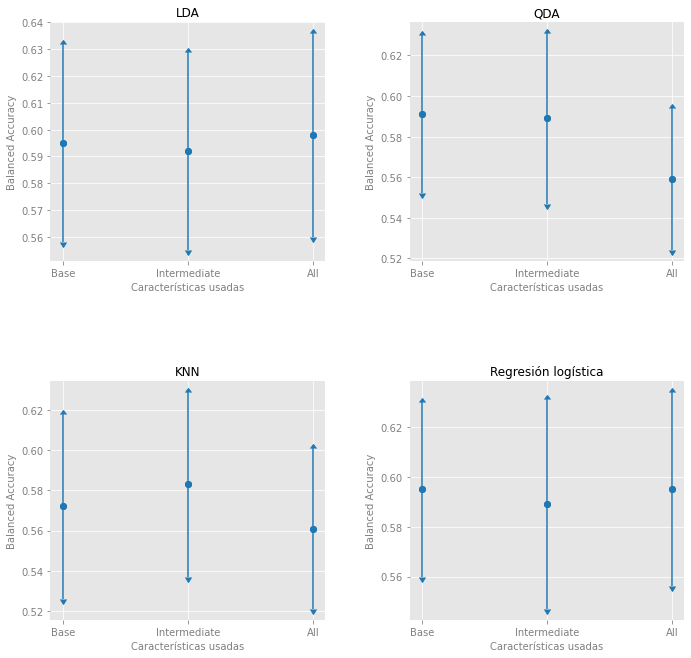

In [ ]:
x1 = ["Base", "Intermediate", "All"]
x2 = ["Base", "Intermediate", "All"]
x3 = ["Base", "Intermediate", "All"]
x4 = ["Base", "Intermediate", "All"]

fig, axs = plt.subplots(2, 2)

y1 = [mean_base_lda, mean_mid_lda, mean_all_lda]
y1_error = [std_base_lda, std_mid_lda, std_all_lda]
axs[0, 0].scatter(x1, y1)
axs[0, 0].set_title('LDA')
axs[0, 0].errorbar(x1, y1, yerr= y1_error,fmt='o', uplims=True, lolims=True)
axs[0, 0].grid(color='w', linestyle='solid')
axs[0, 0].set_xlabel('Características usadas')
axs[0, 0].set_ylabel('Balanced Accuracy')

y2 = [mean_base_qda, mean_mid_qda, mean_all_qda]
y2_error = [std_base_qda, std_mid_qda, std_all_qda]
axs[0, 1].scatter(x2, y2)
axs[0, 1].set_title('QDA')
axs[0, 1].errorbar(x2, y2, yerr= y2_error,fmt='o', uplims=True, lolims=True)
axs[0, 1].grid(color='w', linestyle='solid')
axs[0, 1].set_xlabel('Características usadas')
axs[0, 1].set_ylabel('Balanced Accuracy')

y3 = [mean_base_knn, mean_mid_knn, mean_all_knn]
y3_error = [std_base_knn, std_mid_knn, std_all_knn]
axs[1, 0].scatter(x3, y3)
axs[1, 0].set_title('KNN')
axs[1, 0].errorbar(x3, y3, yerr= y3_error,fmt='o', uplims=True, lolims=True)
axs[1, 0].grid(color='w', linestyle='solid')
axs[1, 0].set_xlabel('Características usadas')
axs[1, 0].set_ylabel('Balanced Accuracy')

y4 = [mean_base_logreg, mean_mid_logreg, mean_all_logreg]
y4_error = [std_base_logreg, std_mid_logreg, std_all_logreg]
axs[1, 1].scatter(x4, y4)
axs[1, 1].set_title('Regresión logística')
axs[1, 1].errorbar(x4, y4, yerr= y4_error, fmt='o', uplims=True, lolims=True)
axs[1, 1].grid(color='w', linestyle='solid')
axs[1, 1].set_xlabel('Características usadas')
axs[1, 1].set_ylabel('Balanced Accuracy')


plt.grid(color='w', linestyle='solid')
for ax in [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]:
    ax.set_axisbelow(True)
    ax.set_facecolor('#E6E6E6')
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()

    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')

    ax.tick_params(colors='gray', direction='out')
    for tick in ax.get_xticklabels():
        tick.set_color('gray')
    for tick in ax.get_yticklabels():
        tick.set_color('gray')


fig.tight_layout(pad=0.1)
fig.set_size_inches(10,10)

plt.show()


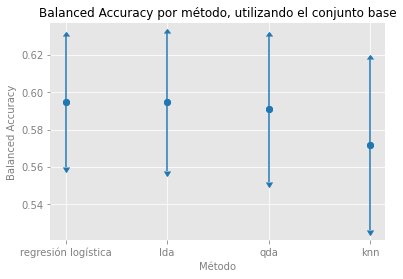

In [ ]:
x= ["regresión logística", "lda", "qda", "knn"]
y= [mean_base_logreg, mean_base_lda, mean_base_qda, mean_base_knn]

y_error = [std_base_logreg, std_base_lda, std_base_qda, std_base_knn]

ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.scatter(x,y)
plt.errorbar(x, y, yerr= y_error,fmt='o', uplims=True, lolims=True)
plt.grid()
plt.title('Balanced Accuracy por método, utilizando el conjunto base')
plt.xlabel('Método')
plt.ylabel('Balanced Accuracy')

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

plt.show()

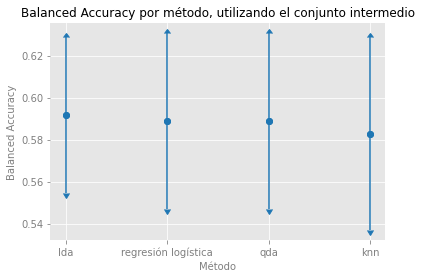

In [ ]:
x= ["lda", "regresión logística", "qda", "knn"]
y= [mean_mid_lda, mean_mid_logreg, mean_mid_qda, mean_mid_knn]

y_error = [std_mid_lda, std_mid_logreg, std_mid_qda, std_mid_knn]

ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.scatter(x,y)
plt.errorbar(x, y, yerr= y_error,fmt='o', uplims=True, lolims=True)
plt.grid()
plt.title('Balanced Accuracy por método, utilizando el conjunto intermedio')
plt.xlabel('Método')
plt.ylabel('Balanced Accuracy')

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')


plt.show()

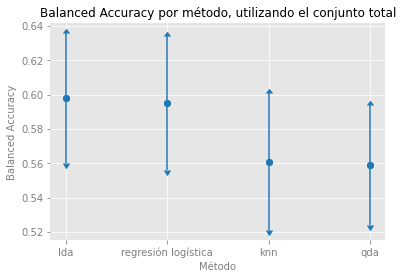

In [ ]:
x= ["lda", "regresión logística", "knn", "qda"]
y= [mean_all_lda, mean_all_logreg, mean_all_knn, mean_all_qda]

y_error = [std_all_lda, std_all_logreg, std_all_knn, std_all_qda]

ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)

plt.scatter(x,y)
plt.errorbar(x, y, yerr= y_error,fmt='o', uplims=True, lolims=True)
plt.grid()
plt.title('Balanced Accuracy por método, utilizando el conjunto total')
plt.xlabel('Método')
plt.ylabel('Balanced Accuracy')

plt.grid(color='w', linestyle='solid')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.xaxis.label.set_color('gray')
ax.yaxis.label.set_color('gray')

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

plt.show()

### Descargar resultados

In [ ]:
!unzip /content/modelos_balance_accuracy.zip

In [ ]:
!zip -r /content/modelos_balance_accuracy.zip /content/modelos/

In [ ]:
from google.colab import files
files.download("/content/modelos.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -rf modelos/all_features/knn/*